In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

## Step 1: Download images of corgi and bread


In [3]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#NB checkingcorgi
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('corgi photos', max_images=1)
urls[0]

'http://www.101dogbreeds.com/wp-content/uploads/2014/10/Pembroke-Welsh-Corgi-Images.jpg'

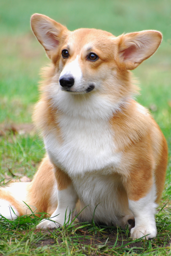

In [5]:
from fastdownload import download_url
dest = 'corgi.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

now to get examples of "corgi" and "bread"

In [6]:
searches = 'corgi', 'bread'
path = Path('corgi_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Step 2: Training model

Getting rid of failed ones

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

Now using data loaders

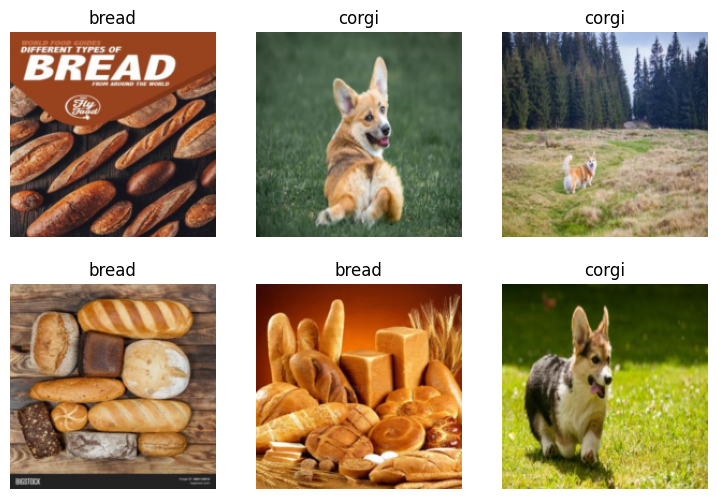

In [8]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label, 
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)
dls.show_batch(max_n=6)

actual learning

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.637716,0.005180,0.000000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.009587,0.005514,0.000000,00:01
1,0.005316,0.006954,0.000000,00:01
2,0.003561,0.017085,0.015625,00:01
3,0.002492,0.039291,0.015625,00:01
4,0.001855,0.051227,0.015625,00:01


## Step 3: Using the model

In [10]:
is_corgi, _, probs = learn.predict(PILImage.create('corgi.jpg'))
print(f"This is a: {is_corgi}.")
print(f"Probability it's a corgi: {probs[0]:.4f}")
print(probs)

This is a: corgi.
Probability it's a corgi: 0.0000
tensor([2.6808e-06, 1.0000e+00])
